In [173]:
%pwd
%cd ../..

/Users/ryandevera/data-science


In [174]:
from deeplifting.models import DeepliftingSkipMLP
from deeplifting.optimization import set_seed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

In [205]:
input_size = 512
hidden_sizes = (128, 128)
dimensions = 2
bounds = [(-10, 10), (-10, 10)]
activation = 'sine'
output_activation = 'sine'
agg_function = 'sum'
trial = 1

model = DeepliftingSkipMLP(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=dimensions,
    bounds=bounds,
    skip_every_n=1,
    activation=activation,
    output_activation=output_activation,
    agg_function=agg_function,
    seed=trial,
)

In [206]:
outputs1 = model(None)

In [207]:
outputs1 = pd.Series(outputs1[:, 0].detach().numpy())

In [208]:
outputs1.describe()

count    512.000000
mean       0.124701
std        0.188738
min       -0.442842
25%       -0.012376
50%        0.125912
75%        0.256332
max        0.697482
dtype: float64

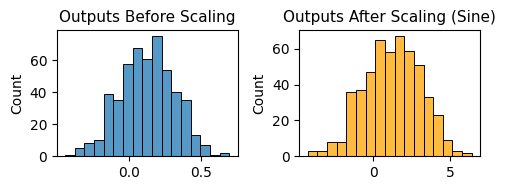

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2))

# Get the neural network outputs before scaling
sns.histplot(outputs1, ax=ax1)
ax1.set_title('Outputs Before Scaling', fontsize=11)
# ax1.axvline(-np.pi / 2.0, color='r')
# ax1.axvline(np.pi / 2.0, color='r')

# Get the neural network outputs after scaling
a, b = -10, 10
outputs1_scale = a + (b - a) / 2.0 * (outputs1.apply(np.sin) + 1)

sns.histplot(outputs1_scale, ax=ax2, color='orange')
ax2.set_title('Outputs After Scaling (Sine)', fontsize=11)

fig.tight_layout()
# fig.savefig(
#     '/Users/ryandevera/data-science/umn_environments/Deeplifting'
#     f'/images/scaling.png',
#     bbox_inches='tight',
#     pad_inches=0.01,
# )

In [213]:
outputs1_scale.describe()

count    512.000000
mean       3.839667
std        5.790305
min      -13.462015
25%       -0.388791
50%        3.945194
75%        7.964994
max       20.178125
dtype: float64

In [106]:
np.sinh(outputs1_scale).describe()

count    5.120000e+02
mean    -1.553658e+06
std      1.255897e+07
min     -2.423190e+08
25%     -1.666130e+05
50%     -1.490147e+04
75%     -1.587660e+03
max     -1.620753e+00
dtype: float64

In [107]:
np.sinh(5)

74.20321057778875

In [ ]:
(
    -20 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2)))
    - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y)))
    + exp(1)
    + 20
)

In [166]:
from pyomo.environ import (
    ConcreteModel,
    Var,
    Objective,
    Constraint,
    SolverFactory,
    minimize,
    Reals,
)
from pyomo.environ import exp, sqrt, cos
import numpy as np

model = m = ConcreteModel()

# Define variables
m.x1 = Var(within=Reals, bounds=(-32, 32), initialize=-4.0)
m.x2 = Var(within=Reals, bounds=(-32, 32), initialize=0.0)


# Define objective (Ackley function)
def ackley(m):
    x = m.x1
    y = m.x2
    result = (
        -20 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2) + 1e-10))
        - exp(0.5 * (cos(2 * np.pi * x) + cos(2 * np.pi * y)))
        + exp(1)
        + 20
    )
    return result


model.obj = Objective(expr=ackley, sense=minimize)

# Create a solver
solver = SolverFactory('ipopt')

# Solve the model
solver.solve(model, tee=True)

# Print the results
print("Results:")
print("x =", model.x1())
print("y =", model.x2())
print("Objective =", model.obj())

Ipopt 3.14.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number

In [167]:
from jax.config import config

# Enable 64 bit floating point precision
config.update("jax_enable_x64", True)

# We use the CPU instead of GPU und mute all warnings if no GPU/TPU is found.
config.update('jax_platform_name', 'cpu')

import jax.numpy as np
from jax import jit, grad, jacfwd, jacrev
from cyipopt import minimize_ipopt

In [172]:
# third party
import jax.numpy as np
import pandas as pd
from cyipopt import minimize_ipopt

# first party
from deeplifting.utils import (
    initialize_vector,
    set_seed,
)
from deeplifting.problems import PROBLEMS_BY_NAME

problem = PROBLEMS_BY_NAME['ackley']
trials = 1
trial = 0


def objective(x):
    """
    Function that implements the Ackley function in
    numpy or pytorch. We will use this for our deeplifting experiments.
    Note, that this version is the 2-D version only.
    """
    a = 20
    b = 0.2
    c = 2 * np.pi

    # sum_sq_term = -a * np.exp(-b * np.sqrt(0.5 * (x[0]**2 + x[1]**2)))
    # cos_term = -np.exp(0.5 * (np.cos(c * x[0]) + np.cos(c * x[1])))
    # result = sum_sq_term + cos_term + a + np.exp(1)

    return (
        -a * np.exp(-b * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2) + 1e-10))
        + -np.exp(0.5 * (np.cos(c * x[0]) + np.cos(c * x[1])))
        + a
        + np.exp(1)
    )


# jit the functions
obj_jit = jit(objective)

# build the derivatives and jit them
obj_grad = jit(grad(obj_jit))  # objective gradient
obj_hess = jit(jacrev(jacfwd(obj_jit)))  # objective hessian

# Get the maximum iterations
max_iterations = problem['max_iterations']

# Get dimensions of the problem
dimensions = problem['dimensions']

# Get the bounds of the problem
if dimensions <= 2:
    bounds = problem['bounds']
else:
    bounds = problem['bounds']

    if len(bounds) > 1:
        bounds = bounds

    else:
        bounds = bounds * dimensions

set_seed(0)

# Initial guess (starting point for IPOPT)
# TODO: Need to provide a better starting point here
x0 = initialize_vector(size=dimensions, bounds=bounds)
print(x0)

# Call IPOPT
result = minimize_ipopt(
    obj_jit,
    jac=obj_grad,
    # hess=obj_hess,
    x0=x0,
    bounds=bounds,
    options={'disp': 5},
)

[ 3.19904179 14.10265031]
This is Ipopt version 3.14.12, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8385596e+01 0.00e+00 5.29e+00   0.0 0.00e+0

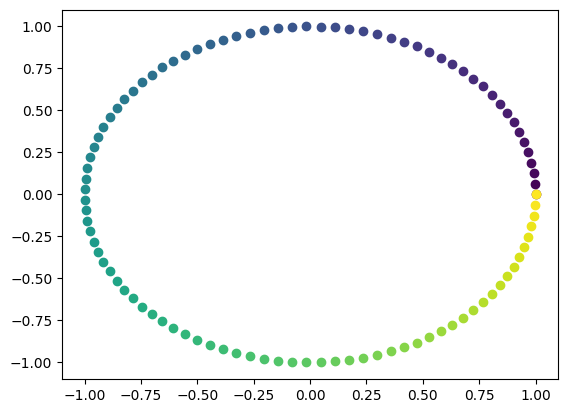

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Example trajectory (for illustration purposes)
trajectory = np.array(
    [[np.cos(theta), np.sin(theta)] for theta in np.linspace(0, 2 * np.pi, 100)]
)

# Create a colormap
colors = cm.viridis(np.linspace(0, 1, len(trajectory)))

fig, ax = plt.subplots()

# Plot each point in the trajectory with a color from the colormap
for i, point in enumerate(trajectory):
    ax.plot(point[0], point[1], 'o', color=colors[i])

plt.show()

In [216]:
import matplotlib.cm as cm

In [250]:
x1, x2 = 1.99999999, 2.01
y1, y2 = np.pi * (x1 - 2), np.pi * (x2 - 2)
(1 - abs(np.sin(y1) * np.sin(y2) / ((y1 * y2)) ** 5)) * (
    2 + (x1 - 7) ** 2 + 2 * (x2 - 7) ** 2
)

-8.092672019884446e+37

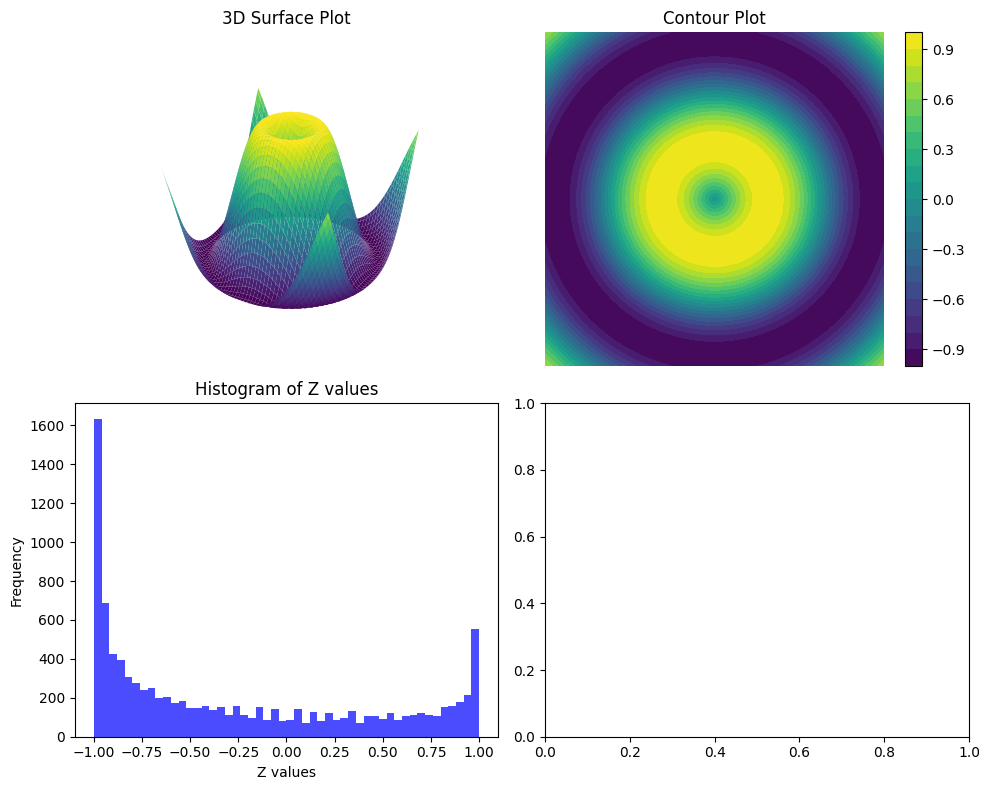

In [261]:
import numpy as np
import matplotlib.pyplot as plt


# Define the function
def f(x, y):
    return np.sin(np.sqrt(x**2 + y**2))


# Generate data
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Set up subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 1].axis('off')  # Turn off the top-right subplot as it's not used
axs[0, 0].axis('off')

# 3D Surface plot
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('3D Surface Plot')
ax.axis('off')

# Contour plot
c = axs[0, 1].contourf(X, Y, Z, 20, cmap='viridis')
fig.colorbar(c, ax=axs[0, 1])
axs[0, 1].set_title('Contour Plot')

# Histogram
axs[1, 0].hist(Z.ravel(), bins=50, color='blue', alpha=0.7)
axs[1, 0].set_title('Histogram of Z values')
axs[1, 0].set_xlabel('Z values')
axs[1, 0].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

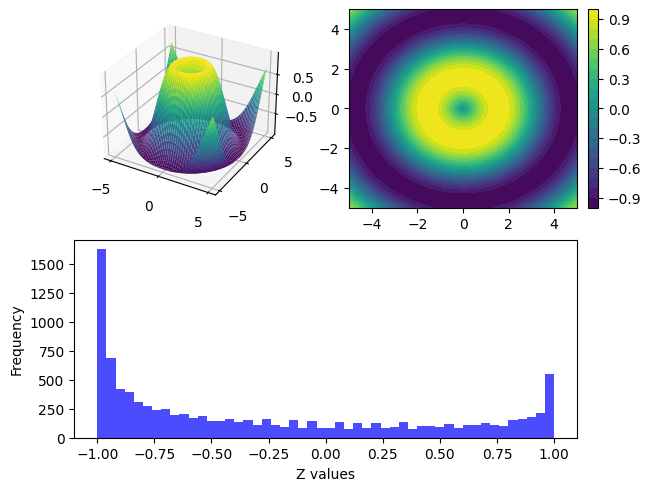

In [274]:
import numpy as np
import matplotlib.pyplot as plt


# Define the function
def f(x, y):
    return np.sin(np.sqrt(x**2 + y**2))


# Generate data
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Define the layout
layout = """
    AB
    CC
"""

fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(
    layout,
    per_subplot_kw={
        "A": {"projection": "3d"},
    },
)

# 3D Surface plot
ax3d = ax_dict['A']
ax3d.plot_surface(X, Y, Z, cmap='viridis')

# Contour plot
c = ax_dict['B'].contourf(X, Y, Z, 20, cmap='viridis')
fig.colorbar(c, ax=ax_dict['B'])

# Histogram
ax_dict['C'].hist(Z.ravel(), bins=50, color='blue', alpha=0.7)
ax_dict['C'].set_xlabel('Z values')
ax_dict['C'].set_ylabel('Frequency')

plt.show()

In [266]:
dir(ax_dict['A'])

['ArtistList',
 '_AxesBase__clear',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autotitlepos',
 '_axes',
 '_axes_locator',
 '_axis_map',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_errorevery_to_mask',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_fully_clipped_to_axes',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spine

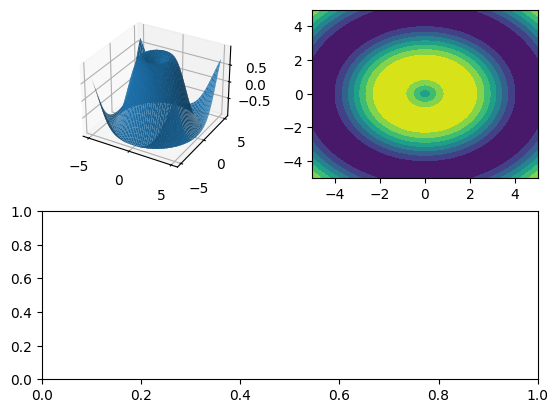

In [273]:
fig, axd = plt.subplot_mosaic(
    "AB;CC",
    per_subplot_kw={
        "A": {"projection": "3d"},
    },
)

axd['A'].plot_surface(X, Y, Z)
axd['B'].contourf(X, Y, Z)